In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import torch 
import os
import cv2
from PIL import Image
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,random_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

KeyboardInterrupt: 

Clean Data

In [ ]:
device=torch.device("cuda")

In [ ]:
data_dir="data"

In [ ]:
def get_image_formats(folder):
    formats = set()
    for root, _, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            try:
                with Image.open(path) as img:
                    formats.add(img.format)
            except:
                pass
    return formats

folder = "data"
print(get_image_formats(folder))

{'PNG'}


In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
count=0
for img_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,img_class)):
        img_path=os.path.join(data_dir,img_class,image)
        try:
            op=cv2.imread(img_path)
            img = Image.open(img_path) 
            ty = img.format.lower()
            if ty not in image_exts:
                print('Image not in ext list {}'.format(img_path))
                os.remove(img_path)
                count+=1
        except:    
             print('Issue with image {}'.format(img_path))
             os.remove(img_path)
             count+=1
print(count)             

0


In [ ]:
transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()],transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]))

In [ ]:
dataset=datasets.ImageFolder(root=data_dir,transform=transform)

In [ ]:
data_lo=DataLoader(dataset,batch_size=16,shuffle=True)

In [ ]:
data_iter = iter(data_lo)  
images, labels = next(data_iter)
print(images.shape)  
print(labels[:16])  


torch.Size([16, 3, 224, 224])
tensor([0, 1, 0, 1, 1, 0, 0, 2, 1, 2, 0, 0, 2, 0, 0, 1])


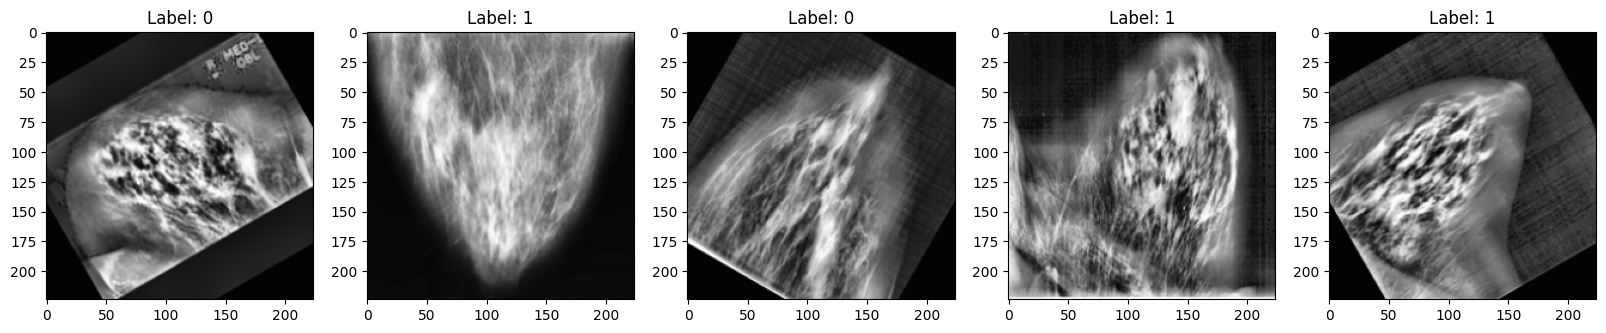

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 20))

for i in range(5):
    img = images[i].permute(1, 2, 0)  # (H, W, C)
    ax[i].imshow(img)
    ax[i].set_title(f"Label: {labels[i].item()}")

plt.show()

In [ ]:
int(len(dataset))

9375

In [ ]:

train_data_s=int(.7*len(dataset))
val_data_s=int(.15*len(dataset))
test_data_s=int(len(dataset))-train_data_s-val_data_s
#-----------------------------------------------------------------------------------------------------
seed = 42  
generator = torch.Generator().manual_seed(seed)

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_data_s, val_data_s, test_data_s],
    generator=generator
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



In [ ]:
print(train_data_s,test_data_s,val_data_s)

6562 1407 1406


In [ ]:
net=models.resnet18(pretrained=True)    # yolo
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 3)

c:\Users\Cc\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Cc\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_counts = [3660,3689,2000]
weights = [1.0 / c for c in class_counts]  
weights = torch.tensor(weights, dtype=torch.float32)
weights = torch.tensor(weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

#-------------------------------------------------------------------------------
optimizer = optim.Adam(net.parameters(), lr=.00001)


C:\Users\Cc\AppData\Local\Temp\ipykernel_13392\4072098412.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(weights, dtype=torch.float32).to(device)


In [ ]:
net.to(device)
torch.cuda.manual_seed(42)
eposhs =6
accs=[]
train_losses = []
test_losses = []
eposhs_count = []

for epoch in range(eposhs):
    net.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    
    # -------- Evaluation --------
    net.eval()
   
    running_test_loss, correct = 0.0, 0   # << هنا الإضافة

    with torch.no_grad():
        
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    
    acc = correct / len(val_loader.dataset)

    test_loss = running_test_loss / len(val_loader.dataset)
    
    # -------- Save every 10 epochs --------
    if epoch % 1== 0:
        accs.append(acc)
        eposhs_count.append(epoch)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | acc : {acc}")



Epoch: 0 | Train Loss: 0.2981 | Test Loss: 0.0604 | acc : 0.9800853485064012
Epoch: 1 | Train Loss: 0.0604 | Test Loss: 0.0374 | acc : 0.9836415362731152
Epoch: 2 | Train Loss: 0.0344 | Test Loss: 0.0219 | acc : 0.9921763869132291
Epoch: 3 | Train Loss: 0.0217 | Test Loss: 0.0156 | acc : 0.9914651493598862
Epoch: 4 | Train Loss: 0.0139 | Test Loss: 0.0168 | acc : 0.9950213371266002
Epoch: 5 | Train Loss: 0.0124 | Test Loss: 0.0218 | acc : 0.9928876244665719


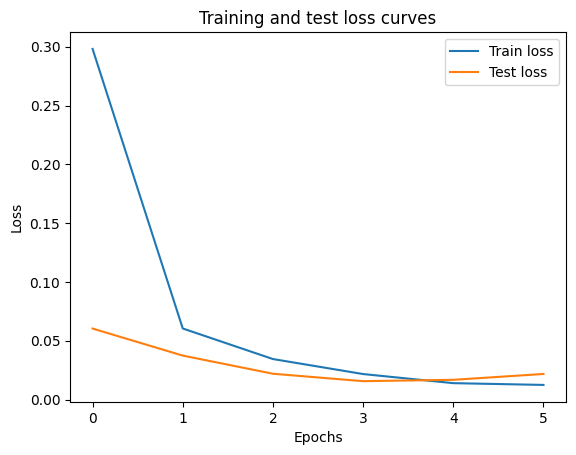

In [ ]:
plt.plot(eposhs_count, train_losses, label="Train loss")
plt.plot(eposhs_count, test_losses, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.Figure(figsize=(15,15))

plt.xlabel("Epochs")
plt.legend();

In [ ]:
torch.save(net.state_dict(), "resnet_weights1.pth")

In [ ]:
print(dataset.classes)

['benign', 'malignant', 'normal']


In [ ]:
model =models. resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)   
model.load_state_dict(torch.load("resnet_weights1.pth"))

<All keys matched successfully>

In [ ]:
img_path = "nn.png"
img = Image.open(img_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img = transform(img).unsqueeze(0).to(device)
model = model.to(device)
# prediction
model.eval()
with torch.no_grad():
    outputs = model(img)
    _, preds = torch.max(outputs, 1)

classes = ['benign', 'malignant', 'normal']
print(f"Prediction: {classes[preds.item()]}")

Prediction: normal
